Testing `mushi` with `msprime` simulations
==

In [1]:
%matplotlib notebook
import mushi
import msprime
from IPython.display import display, SVG
import numpy as np
from matplotlib import pyplot as plt
from scipy.special import expit
import time

## `msprime` simulation
### simulation parameters

In [2]:
Ne = 1000
μ0 = 1e-8
n = 200
# recombination rate
r = 1e-8
# chromosome length
ℓ = 1e8

### run simulation and print number of linkage blocks, also plot the first tree in the sequence

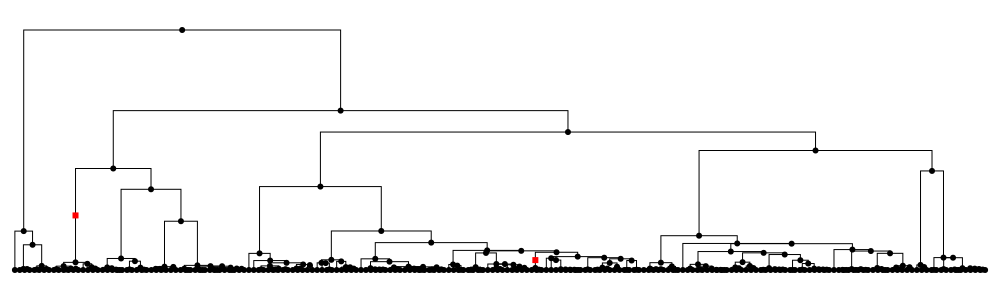

20405 linkage blocks


In [3]:
seed = time.time()
tree_sequence = msprime.simulate(sample_size=n, Ne=Ne, length=ℓ, recombination_rate=r,
                                 mutation_rate=μ0, random_seed=seed)
display(SVG(tree_sequence.first().draw(format='svg', width=1000, height=300, node_labels={},
                                       mutation_labels={})))#, max_tree_height='ts')))
print(f'{len(tree_sequence.breakpoints(as_array=True))} linkage blocks')

### compute and plot the SFS

<IPython.core.display.Javascript object>


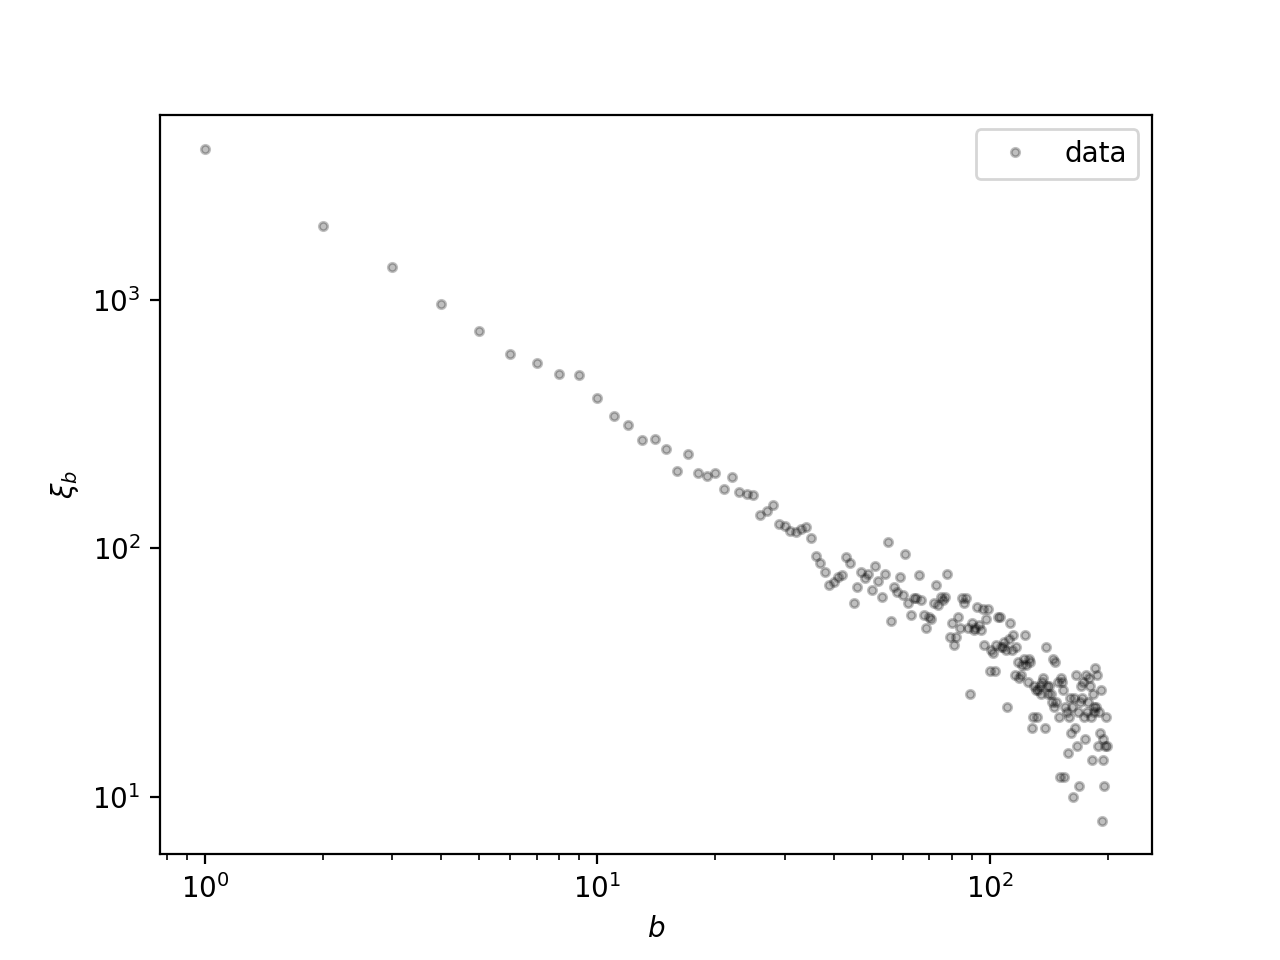

In [4]:
x = tree_sequence.allele_frequency_spectrum(polarised=True, span_normalise=False)[1:-1]
sfs = mushi.SFS(n=None, x=x)

plt.figure()
sfs.plot()
plt.show()

## Inferring $\mu(t)$ with `mushi`
### Define true demographic history $\eta(t)$ and mutation rate history $\mu(t)$

<IPython.core.display.Javascript object>


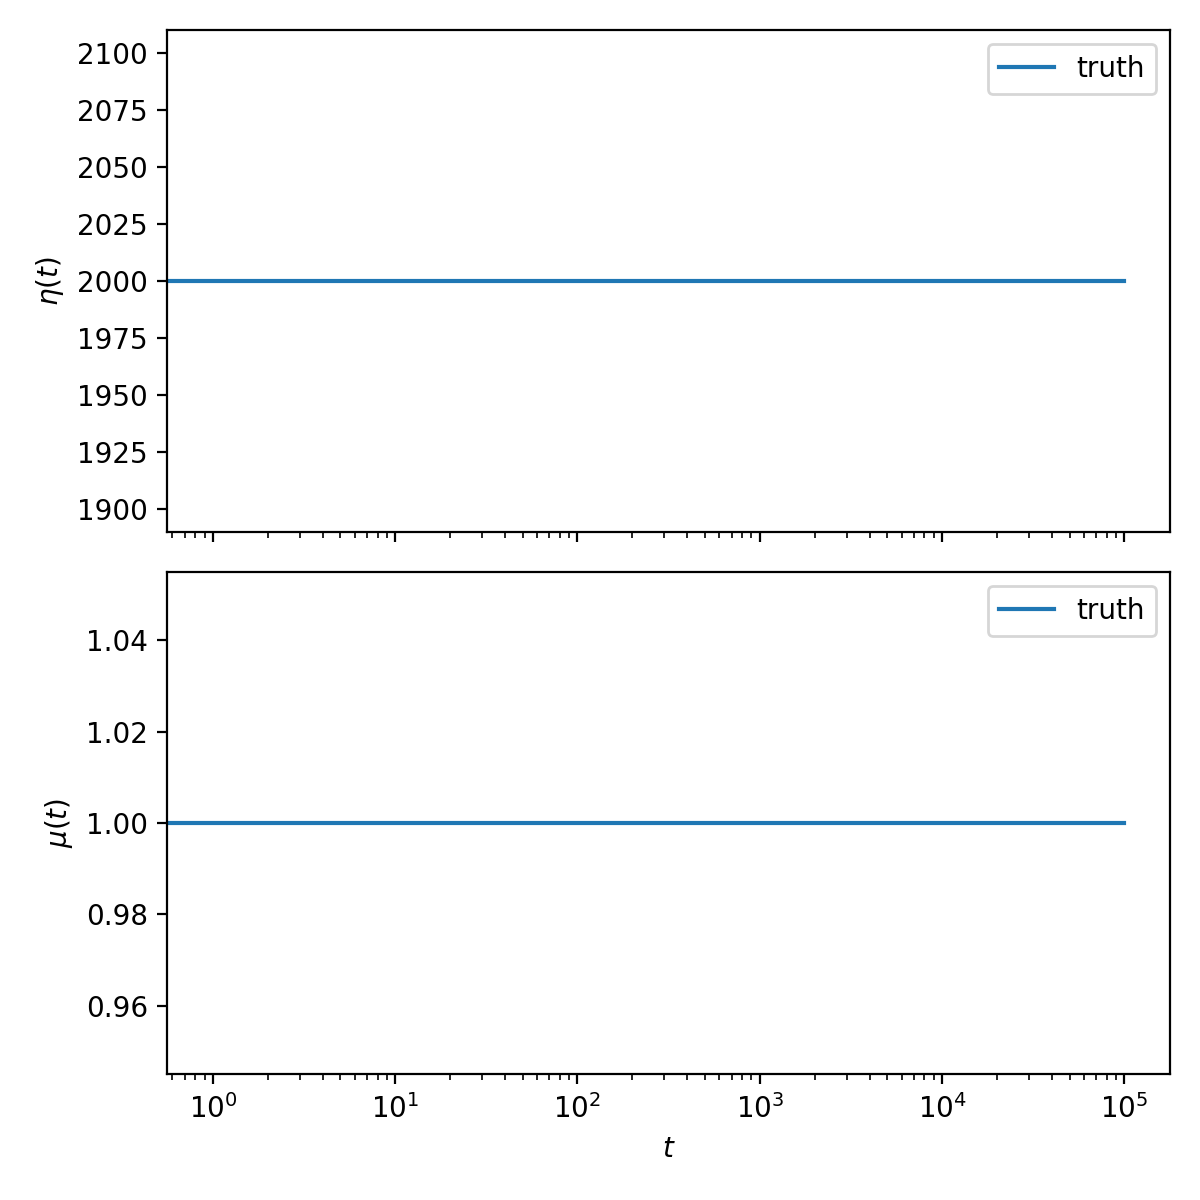

In [5]:
t = np.logspace(0, 5, 200)

# note: the factor of two accounts for diploidy
y = 2 * Ne * np.ones(len(t) + 1)
η = mushi.PiecewiseConstantHistory(t, y)

# note: the factor of ℓ is needed to scale the mutation rate from sites to genomes
z = μ0 * ℓ * np.ones(len(t) + 1)
μ = mushi.PiecewiseConstantHistory(t, z)

history = mushi.JointHistory(η, μ)

fig = history.plot(label='truth')
plt.xscale('log')
plt.tight_layout()
plt.show()

### TMRCA CDF

<IPython.core.display.Javascript object>


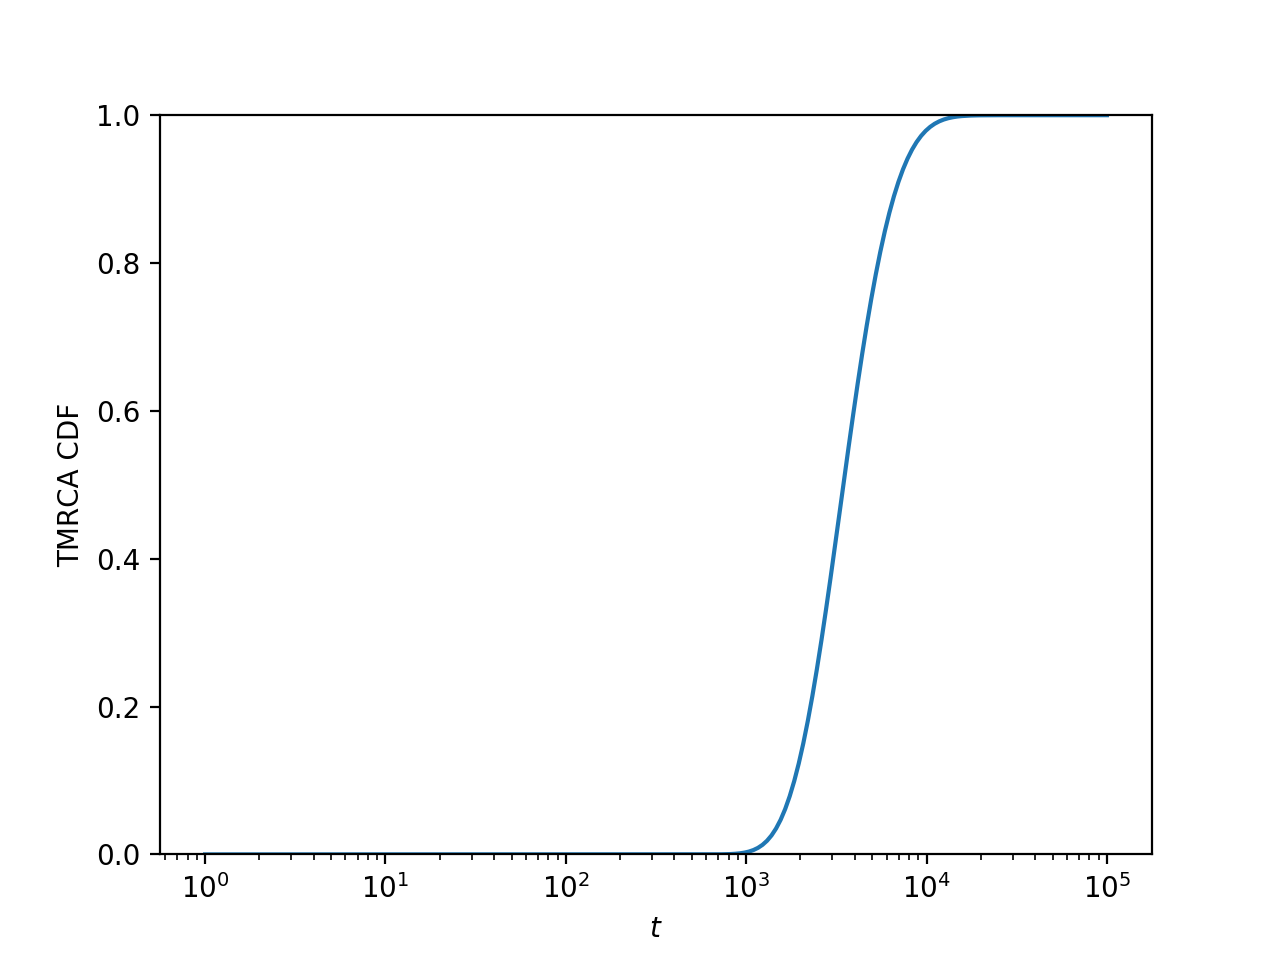

In [6]:
plt.figure()
plt.plot(η.change_points, sfs.tmrca_cdf(history.η))
plt.xlabel('$t$')
plt.xscale('log')
plt.ylim([0, 1])
plt.ylabel('TMRCA CDF')
plt.show()

### Invert the `TCC>TTC` SFS conditioned on $\eta(t)$ to get $\mu(t)$

<IPython.core.display.Javascript object>


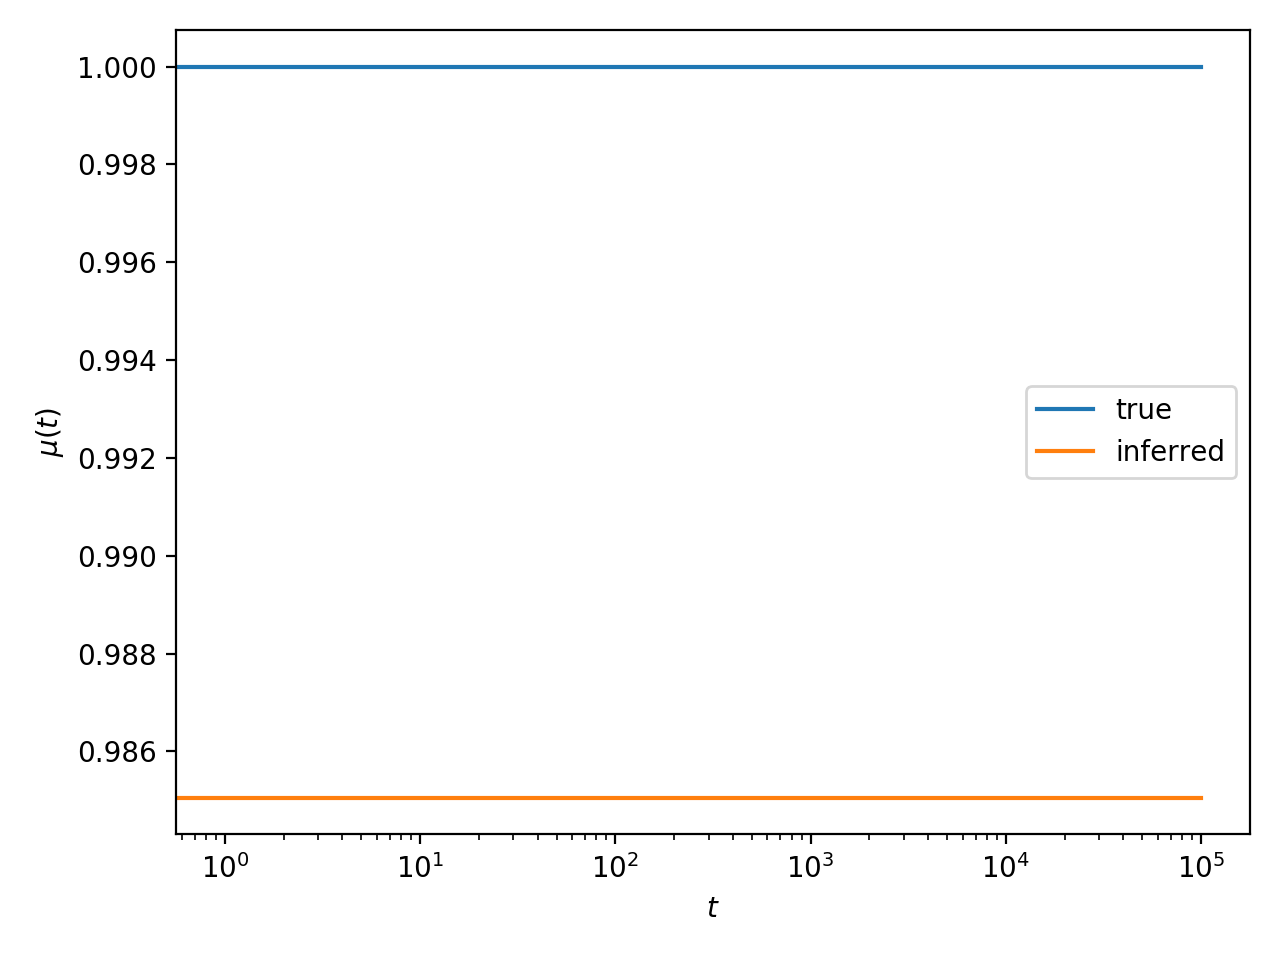

<IPython.core.display.Javascript object>


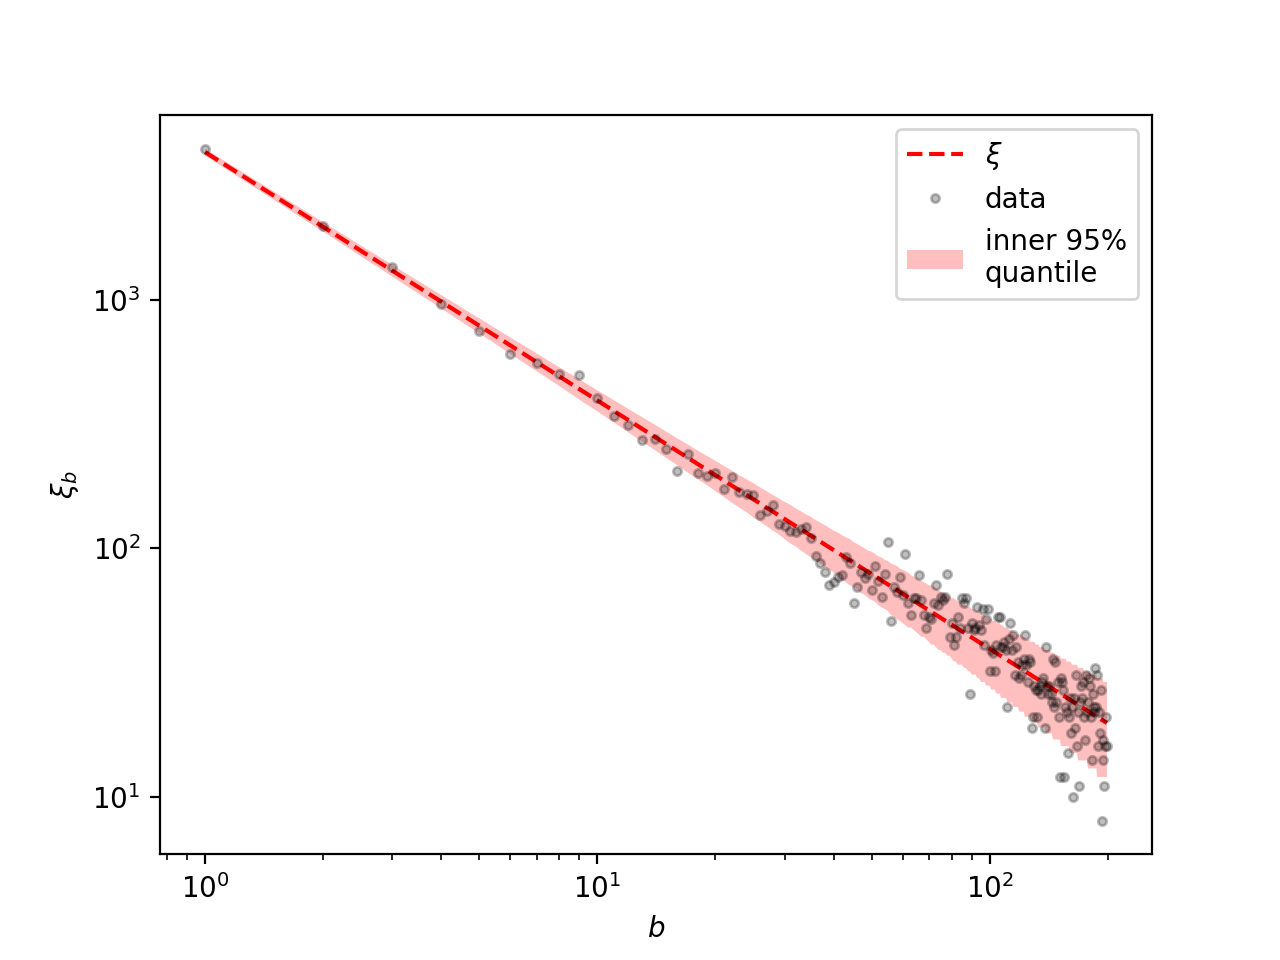

In [7]:
λ = 1e-2
α = .99
s = 1e-5
steps = 20000
μ_inferred = sfs.infer_μ(η, λ=λ, α=α, s=s, steps=steps)

history_inferred = mushi.JointHistory(η, μ_inferred)

plt.figure()
history.μ.plot(label='true')
history_inferred.μ.plot(label='inferred')
plt.xlabel('$t$')
plt.ylabel('$μ(t)$')
plt.xscale('log')
plt.tight_layout()
plt.show()

plt.figure()
sfs.plot(history_inferred)
plt.show()